In [1]:
import re
import pandas as pd

#read the text file
path = "D:\Internships\Projects\Sentiment\chat.txt"
f = open(path, 'r', encoding='utf-8')
data = f.read()
print(type(data))

#regular expression to find the dates
pattern = '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s'

#pass the pattern and data to split it to get the list of messages
messages = re.split(pattern, data)[1:]
print(messages)

#extract all dates
dates = re.findall(pattern, data)

#create dataframe
df = pd.DataFrame({'user_message': messages, 'message_date': dates})
# convert message_date type
df['message_date'] = pd.to_datetime(df['message_date'],format='%d/%m/%y, %H:%M - ')
df.rename(columns={'message_date': 'date'}, inplace=True)
df.head(4)

<class 'str'>
['~\u202fAvinash Singh created group "DSA discussion Group ( Let\'s Code) "\n', 'You were added\n', "+91 86004 25225 joined using this group's invite link\n", '+91 78989 76189: Anybody who have Flipkart interview questions related material...\n', '+91 82404 20228: Role?\n', "+91 82404 20228: If sde/sre, checkout interviewbit's collection. They are nice\n", '+91 6302 508 789: <Media omitted>\n', "+91 93699 79063: It's fake, someone has shared it in other discussion group!\n", '+91 97376 35737: Did you applied?\n', '+91 6302 508 789: Ha i attend one coding round and five minutes of interview and they send send a Google form .The form regarding hr round.i filled it.\n', '+91 6302 508 789: Ok bro\n', '+91 93699 79063: <Media omitted>\n', '+91 94430 51778: <Media omitted>\n', '+91 86175 52201: Rent\n', '+91 86175 52201: Center\n', '+91 86175 52201: Centre\n', '+91 84960 97854: centre\n', '+91 84960 97854: recent\n', '+91 87546 59759: Tent\n', '+91 88227 21103: Anyone having ch

,user_message,date
0,"~ Avinash Singh created group ""DSA discussion ...",2023-06-14 20:40:00
1,You were added\n,2023-06-14 20:40:00
2,+91 86004 25225 joined using this group's invi...,2023-09-17 22:04:00
3,+91 78989 76189: Anybody who have Flipkart int...,2023-09-18 09:52:00


In [2]:
#separate Users and Message
users = []
messages = []
for message in df['user_message']:
    entry = re.split('([\w\W]+?):\s', message)
    if entry[1:]:  # user name
        users.append(entry[1])
        messages.append(" ".join(entry[2:]))
    else:
        users.append('group_notification')
        messages.append(entry[0])

df['user'] = users
df['message'] = messages
df.drop(columns=['user_message'], inplace=True)

In [3]:
df['only_date'] = df['date'].dt.date
df['year'] = df['date'].dt.year
df['month_num'] = df['date'].dt.month
df['month'] = df['date'].dt.month_name()
df['day'] = df['date'].dt.day
df['day_name'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

In [4]:
#add period column that shows data capture between which 24 hour format
period = []
for hour in df[['day_name', 'hour']]['hour']:
    if hour == 23:
        period.append(str(hour) + "-" + str('00'))
    elif hour == 0:
        period.append(str('00') + "-" + str(hour + 1))
    else:
        period.append(str(hour) + "-" + str(hour + 1))

df['period'] = period
df.head()

,date,user,message,only_date,year,month_num,month,day,day_name,hour,minute,period
0,2023-06-14 20:40:00,group_notification,"~ Avinash Singh created group ""DSA discussion ...",2023-06-14,2023,6,June,14,Wednesday,20,40,20-21
1,2023-06-14 20:40:00,group_notification,You were added\n,2023-06-14,2023,6,June,14,Wednesday,20,40,20-21
2,2023-09-17 22:04:00,group_notification,+91 86004 25225 joined using this group's invi...,2023-09-17,2023,9,September,17,Sunday,22,4,22-23
3,2023-09-18 09:52:00,+91 78989 76189,Anybody who have Flipkart interview questions ...,2023-09-18,2023,9,September,18,Monday,9,52,9-10
4,2023-09-18 10:50:00,+91 82404 20228,Role?\n,2023-09-18,2023,9,September,18,Monday,10,50,10-11


In [5]:
#Total Messages
df.shape[0]

276

In [6]:
#Total Number of words
words = []
for message in df['message']:
  words.extend(message.split())

print(len(words))

3600


In [7]:
#Number of Media Files shared
df[df['message'] == '<Media omitted>\n'].shape[0]

18

In [8]:
!pip install urlextract

#Number of Links Shared
from urlextract import URLExtract
extract = URLExtract()

links = []
for message in df['message']:
    links.extend(extract.find_urls(message))

print(len(links))


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


32


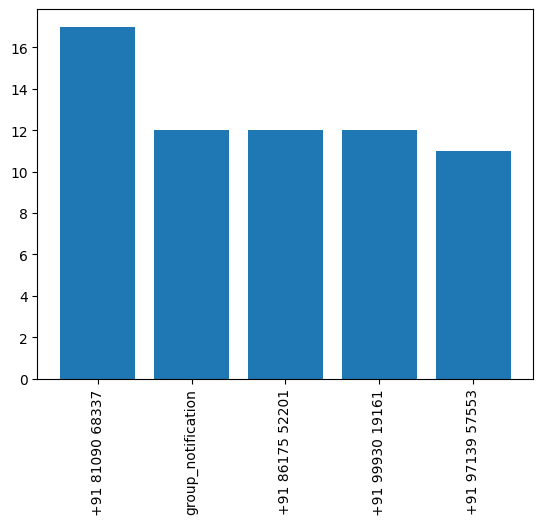

In [9]:
import matplotlib.pyplot as plt

x = df['user'].value_counts().head()
user_names = x.index
msg_count = x.values

plt.bar(user_names, msg_count)
plt.xticks(rotation='vertical')
plt.show()

In [10]:
new_df = round(((df['user'].value_counts() / df.shape[0]) * 100), 2).reset_index().rename(
        columns={'index': 'name', 'user': 'percent'})

new_df.head()

,name,percent
0,+91 81090 68337,6.16
1,group_notification,4.35
2,+91 86175 52201,4.35
3,+91 99930 19161,4.35
4,+91 97139 57553,3.99


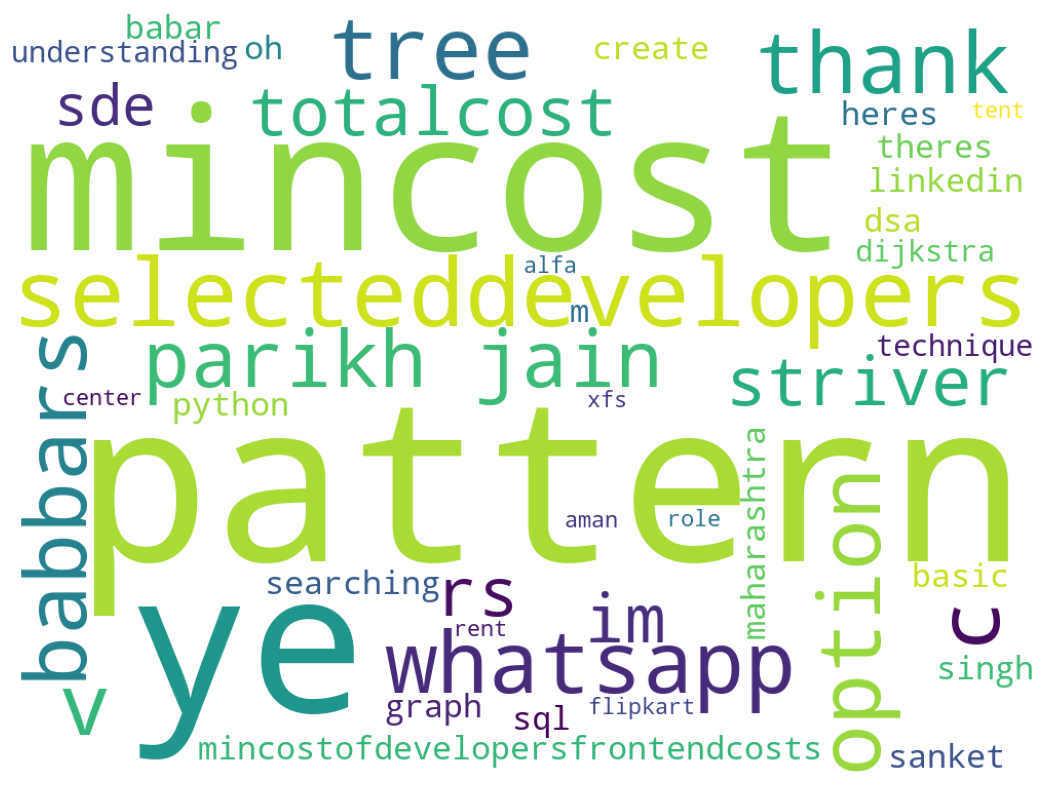

In [11]:
import string
import re
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to remove stop words
def remove_stop_words(message):
    with open('chat.txt', 'r', encoding='utf-8') as f:
        stop_words = f.read().split()
    y = []
    for word in message.lower().split():
        if word not in stop_words:
            y.append(word)
    return " ".join(y)

# Function to remove punctuation
def remove_punctuation(message):
    return re.sub('[%s]' % re.escape(string.punctuation), '', message)

# Data Cleaning
temp = df[df['user'] != 'group_notification']  # Remove group notifications
temp = temp[temp['message'] != '<Media omitted>\n']  # Remove media messages
temp['message'] = temp['message'].apply(remove_stop_words)  # Remove stopwords
temp['message'] = temp['message'].apply(remove_punctuation)  # Remove punctuations

# Draw the WordCloud
plt.figure(figsize=(20, 10))
wc = WordCloud(width=1000, height=750, min_font_size=10, background_color='white')
cloud = wc.generate(temp['message'].str.cat(sep=" "))
plt.imshow(cloud)
plt.axis('off')
plt.show()


In [12]:
temp = df[df['user'] != 'group_notification'] #remove group notification
temp = temp[temp['message'] != '<Media omitted>\n']  #remove media msg
temp['message'] = temp['message'].apply(remove_stop_words) #remove stop words
temp['message'] = temp['message'].apply(remove_punctuation) #remove punctuations

words = []
for message in temp['message']:
  words.extend(message.split())

#apply counter
from collections import Counter
most_common_df = pd.DataFrame(Counter(words).most_common(20))
most_common_df

,0,1
0,pattern,8
1,mincost,6
2,selecteddevelopers,5
3,this,5
4,yes,5
5,whatsapp,4
6,option,4
7,c,4
8,v,4
9,babbars,4


In [13]:
pip install emoji

  Obtaining dependency information for emoji from https://files.pythonhosted.org/packages/eb/ba/656d551141750dc944c7f33180d5ecff4dbdad425f7f002016aaaf2274e8/emoji-2.13.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/553.2 kB ? eta -:--:--
   -- ------------------------------------- 30.7/553.2 kB 1.3 MB/s eta 0:00:01
   ------ --------------------------------- 92.2/553.2 kB 1.3 MB/s eta 0:00:01
   ----------- ---------------------------- 163.8/553.2 kB 1.4 MB/s eta 0:00:01
   ---------------- ----------------------- 225.3/553.2 kB 1.5 MB/s eta 0:00:01
   ----------------------------------- ---- 491.5/553.2 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 553.2/553.2 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import emoji

emojis = []
for message in df['message']:
  emojis.extend([c for c in message if c in emoji.EMOJI_DATA])

pd.DataFrame(Counter(emojis).most_common(len(Counter(emojis))))

,0,1
0,👍,4
1,😭,3
2,🤔,2
3,🏻,2
4,✨,2
5,☠,2
6,🥲,2
7,➕,2
8,😄,1
9,💯,1


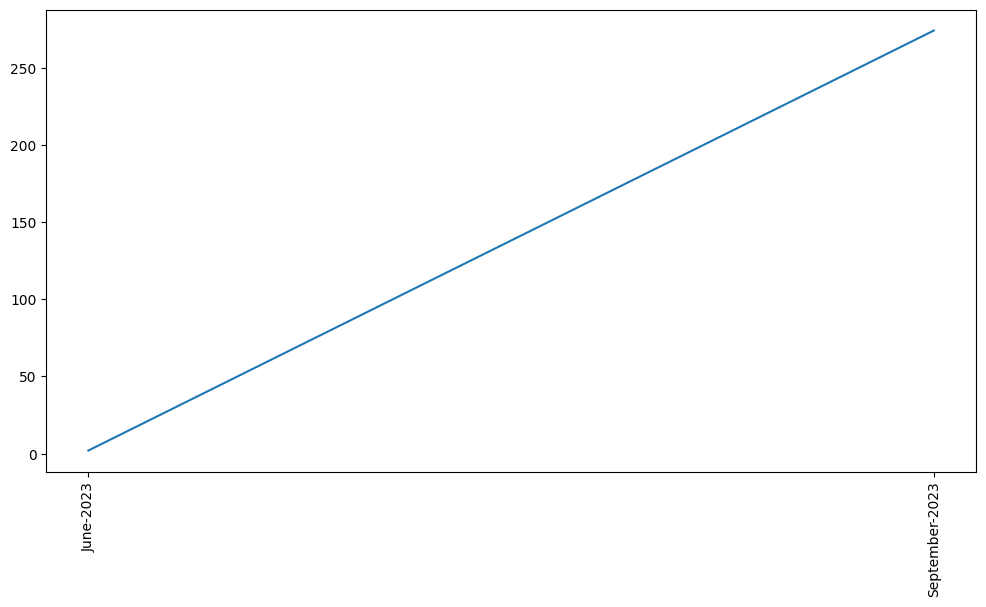

In [15]:
timeline = df.groupby(['year', 'month_num', 'month']).count()['message'].reset_index()
month_timeline = []

for i in range(timeline.shape[0]):
  month_timeline.append(timeline['month'][i] + "-" + str(timeline['year'][i]))

timeline['time'] = month_timeline

#draw plot
plt.figure(figsize=(12,6))
plt.plot(timeline['time'], timeline['message'])
plt.xticks(rotation='vertical')
plt.show()

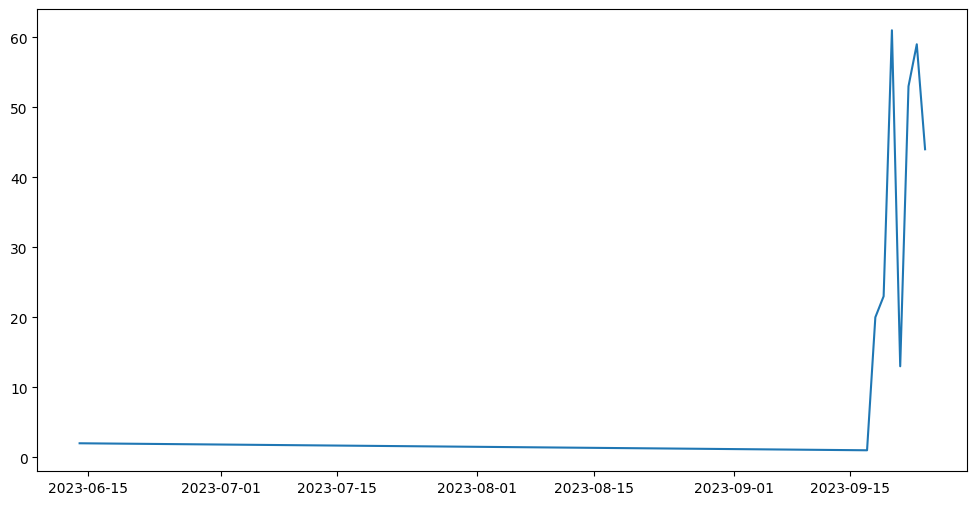

In [16]:
daily_timeline = df.groupby('only_date').count()['message'].reset_index()

plt.figure(figsize=(12,6))
plt.plot(daily_timeline['only_date'], daily_timeline['message'])
plt.show()

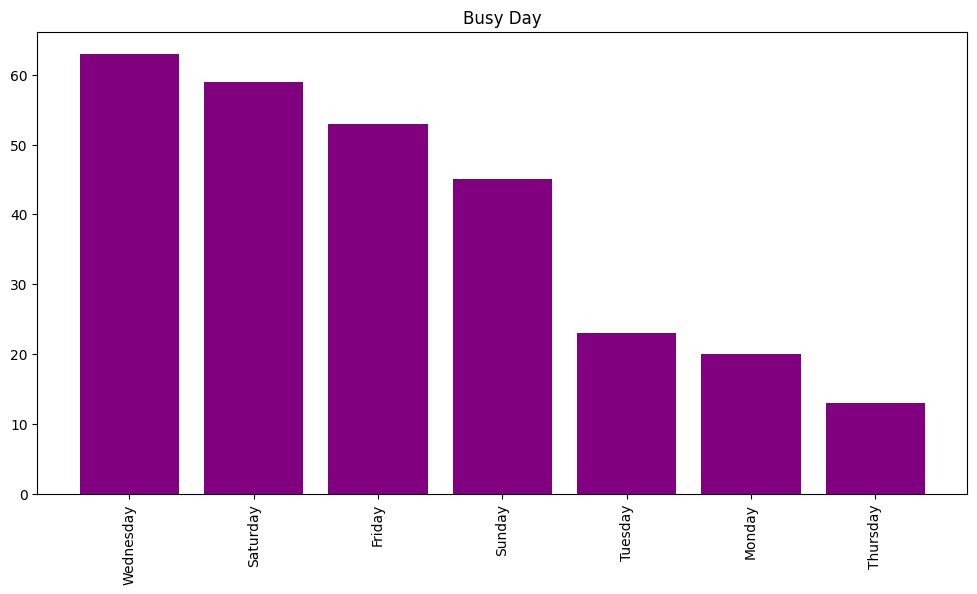

In [17]:
busy_day = df['day_name'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(busy_day.index, busy_day.values, color='purple')
plt.title("Busy Day")
plt.xticks(rotation='vertical')
plt.show()

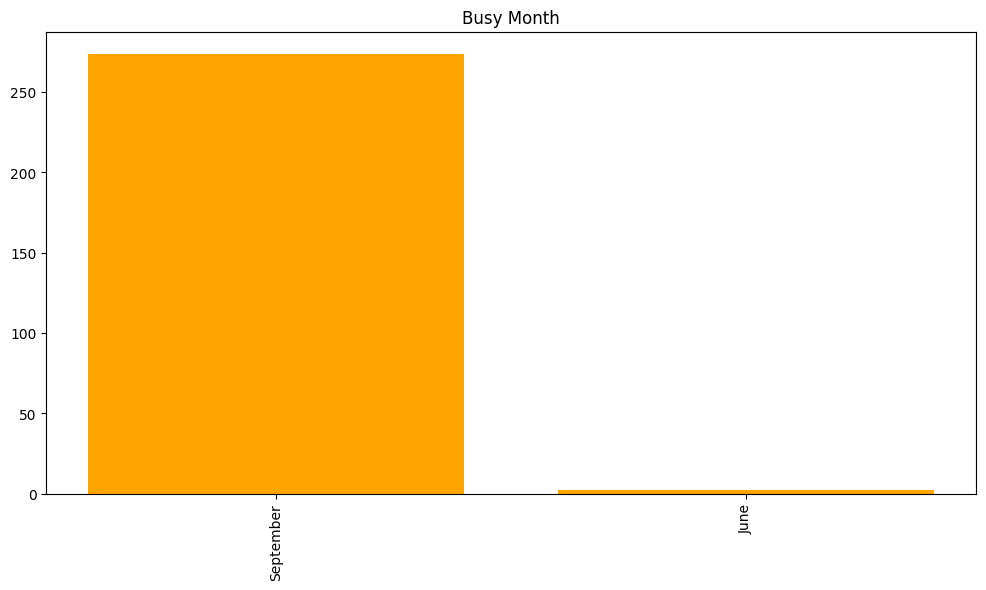

In [18]:
busy_month = df['month'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(busy_month.index, busy_month.values, color='orange')
plt.title("Busy Month")
plt.xticks(rotation='vertical')
plt.show()

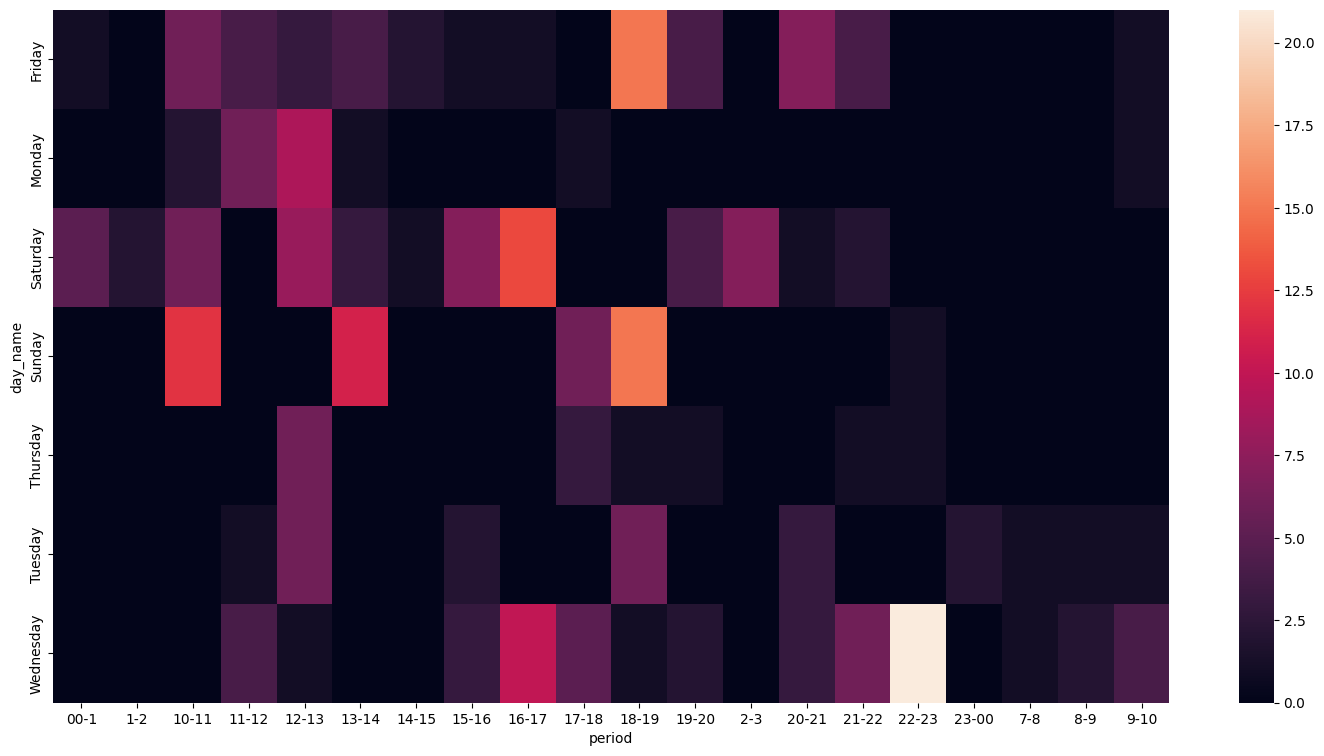

In [19]:
import seaborn as sns
plt.figure(figsize=(18, 9))
sns.heatmap(df.pivot_table(index='day_name', columns='period', values='message',
            aggfunc='count').fillna(0))
plt.yticks(rotation='vertical')
plt.show()